In [1]:
import torch
import torch.nn as nn
from VAE import Encoder, Decoder
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os, glob, random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class VAE(nn.Module): # only for reconstruction not for generation
    def __init__(self, num_variables, num_hiddens, num_residual_layers, num_residual_hiddens,
                 embedding_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(num_variables, num_hiddens,
                                num_residual_layers,
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)

        self.decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens, out_channels=num_variables)

    def forward(self, x):
        z = self.encoder(x)
        z = self._pre_vq_conv(z)
        mu, log_var = torch.chunk(z, 2, dim=1)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var


In [ ]:
from datetime import datetime, timedelta
import time, netCDF4
start_date = datetime(1981, 1, 1)
end_date = datetime(2018, 12, 31)
current_date = start_date
path_data_root = r'/root/autodl-tmp/STA_USA_precip/'
date_list = []
prism = {}
current_date = start_date
while current_date <= end_date:
    print(current_date)
    current_month_endday = datetime(current_date.year, current_date.month + 1, 1) if current_date.month < 12 else datetime(current_date.year, current_date.month, 1) + timedelta(days=31)
    while current_date < current_month_endday:
        path_pr_sr = r'/pr_sr_nc/pr_sr_%s.nc' % current_date.strftime("%Y%m%d")
        pr_sr = netCDF4.Dataset(path_data_root + path_pr_sr).variables['data'][:].data
        pr_sr[pr_sr==-9999] = 0
        prism[current_date.strftime("%Y%m%d")] = np.log(pr_sr + 1)
        for i in range(10): # sample 8°*8° patch 10 times on one day from the CONUS
            date_list.append(current_date.strftime("%Y%m%d"))
        current_date += timedelta(days=1)


In [6]:
import numpy as np
def random_sample(matrix, sample_size):
    rows, cols = matrix.shape
    start_row = np.random.randint(0, rows - sample_size[0] + 1)
    start_col = np.random.randint(0, cols - sample_size[1] + 1)
    sampled_matrix = matrix[start_row:start_row+sample_size[0], start_col:start_col+sample_size[1]]
    return sampled_matrix

def random_sample_fixed(matrix, sample_size, random_x, random_y):
    rows, cols = matrix.shape
    start_row = int(random_x * (rows - sample_size[0]))
    start_col = int(random_y * (cols - sample_size[1]))
    sampled_matrix = matrix[start_row:start_row+sample_size[0], start_col:start_col+sample_size[1]]
    return sampled_matrix

def get_dict_by_second_key(nested_dict, second_key):
    dict_by_second_key = {}
    for key in nested_dict:
        if key in ['lr_p', 'z', 'q', 't', 'u', 'v', 'w']:
            second_dict = nested_dict[key]
            dict_by_second_key[key] = second_dict[second_key]
        else:
            dict_by_second_key[key] = nested_dict[key]
    return dict_by_second_key

def normalize_sample_dict2arr(dictionary, sample_size, random_x, random_y):
    sample_list = []
    for key in dictionary:
        value = dictionary[key]
        if len(value.shape) > 2:
            for i in range(value.shape[0]):
                sample_value = random_sample_fixed(value[i], sample_size, random_x, random_y)
                sample_list.append(sample_value)
        else:
            sample_value = random_sample_fixed(value, sample_size, random_x, random_y)
            sample_list.append(sample_value)
    con_arr = np.array(sample_list)
    return con_arr

class SRDataset(Dataset):
    def __init__(self, data_list, batch_size=64):
        self.data_list = data_list
        self.batch_size = batch_size
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        random_x, random_y = random.random(), random.random()
        data = random_sample_fixed(prism[self.data_list[index]], (192, 192), random_x, random_y)
        pr_transformed = torch.tensor(data).unsqueeze(0)
        return pr_transformed

In [7]:
data_len = len(date_list)
train_data_list = date_list[:int(data_len*0.8)]
test_data_list = date_list[int(data_len*0.8):]
print('train_data_list:', len(train_data_list))
print('test_data_list:', len(test_data_list))


train_data_list: 119800
test_data_list: 29950


In [8]:
train_dataset =SRDataset(train_data_list)
test_dataset = SRDataset(test_data_list)
batch_size = 256
num_workers=8
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                    shuffle=True, pin_memory=True, num_workers=num_workers)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1,
                    shuffle=False, pin_memory=True, num_workers=num_workers)

In [20]:
a = next(iter(train_dataloader))
a.shape

torch.Size([32, 1, 192, 192])

In [ ]:
num_variables = 1
num_hiddens = 256 
num_residual_layers = 2
num_residual_hiddens = 48  
embedding_dim = 4 
learning_rate = 1e-3
VAE = VAE(num_variables, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 embedding_dim).to(device)
VAE.load_state_dict(torch.load('/root/autodl-tmp/result_model/conus/vae_precip.pt'))
optimizer = optim.Adam(VAE.parameters(), lr=learning_rate, amsgrad=False)


In [25]:
import time
from tqdm import tqdm
VAE.train()
train_loss_list = []
train_loss = []
kl_weight = 0.1 # The first few hundred epochs are 0, and the later stages are 0.1
num_epoch = 300
pbar = tqdm(range(num_epoch))
for i in pbar:
    j = 0
    start_time_epoch = time.time()
    for images in train_dataloader:
        j += 1
        data = images.to(device)
        optimizer.zero_grad()
        data_recon, mu, log_var = VAE(data)

        recon_loss = nn.MSELoss()(data_recon, data)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_weight * kl_loss
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    train_mean_loss = np.mean(train_loss)
    train_loss_list.append(train_mean_loss)
    pbar.set_description(f"train loss: {train_mean_loss:.4f}")
    if (i+1) % 10 == 0:
        save_path = '/root/autodl-tmp/model_save/VAE/vae_precip_best_train.pt'
        state_dict = VAE.state_dict()
        optimizer_state_dict = optimizer.state_dict()
        for key, param in state_dict.items():
            state_dict[key] = param.cpu()
        torch.save({
            'model_state_dict': state_dict,
            'optimizer_state_dict': optimizer_state_dict,}, save_path)


100%|██████████| 300/300 [12:26:52<00:00, 149.38s/it]  


In [26]:
save_path = '/root/autodl-tmp/model_save/VAE/'
torch.save(VAE.state_dict(), save_path + 'vae_precip_sr.pt')

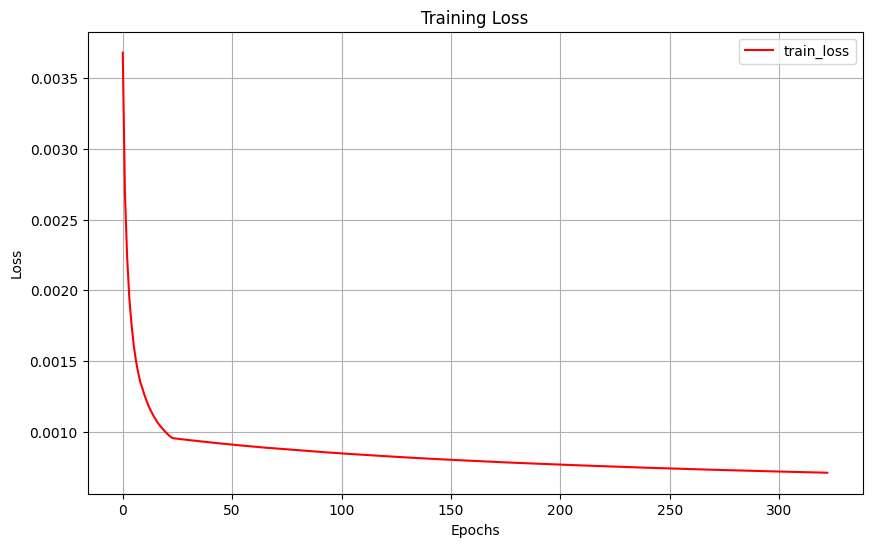

In [29]:
import matplotlib.pyplot as plt

train_loss = train_loss_list # list(np.loadtxt('train_loss_list.txt'))
x = range(len(train_loss))

plt.figure(figsize=(10, 6))
plt.plot(x, train_loss, color='red', label='train_loss')
plt.legend()

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.grid(True)

plt.show()

In [ ]:
num_variables = 1
num_hiddens = 256 
num_residual_layers = 2 
num_residual_hiddens = 48  
embedding_dim = 4 
model = VAE(num_variables, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 embedding_dim).to(device)
model.load_state_dict(torch.load('/root/autodl-tmp/result_model/conus/' + 'vae_precip.pt')['model_state_dict'])

<All keys matched successfully>

In [15]:
from tqdm import tqdm
list_origin, list_latent, list_recon = [], [], []
input_dis, inner_dis, output_dis = [], [], []
for images in tqdm(test_dataloader):
    # if not np.any(np.array(images)==-1):
    data = images.to(device)
    input_dis.append(data[0][0][96][96].item())
    z = model.encoder(data)
    z = model._pre_vq_conv(z)
    inner_dis.append(z[0][2][24][24].item())
    data_recon = model.decoder(z)
    data_recon = data_recon.detach().cpu().numpy()
    data_recon[data_recon<0] = 0
    output_dis.append(data_recon[0][0][96][96])

    list_origin.append(np.array(images))
    list_latent.append(z.detach().cpu().numpy())
    list_recon.append(data_recon)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:51<00:00, 193.41it/s]


In [16]:
import torch
def inverse_log_scaling(tensor):
    return np.exp(tensor)-1

In [17]:
import numpy as np
from PIL import Image

def calculate_rmse(image1, image2):
    rmse_list = []
    for i in range(len(image1)):
        image1[i] = image1[i]
        image2[i] = image2[i]
        assert image1[i].shape == image2[i].shape

        diff = inverse_log_scaling(image1[i]) - inverse_log_scaling(image2[i])
        rmse = np.sqrt(np.mean(diff**2))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

image1_path = list_origin
image2_path = list_recon

rmse = calculate_rmse(image1_path, image2_path)
print("图像之间的均方根误差：", rmse) # the RMSE between precip and recon-precip


图像之间的均方根误差： 0.17367645


In [18]:
list_precip = []
for i, precip in enumerate(list_origin):
    mean_precip = np.mean(inverse_log_scaling(precip))
    if mean_precip > 5.0:
        list_precip.append(i)
len(list_precip)

1005

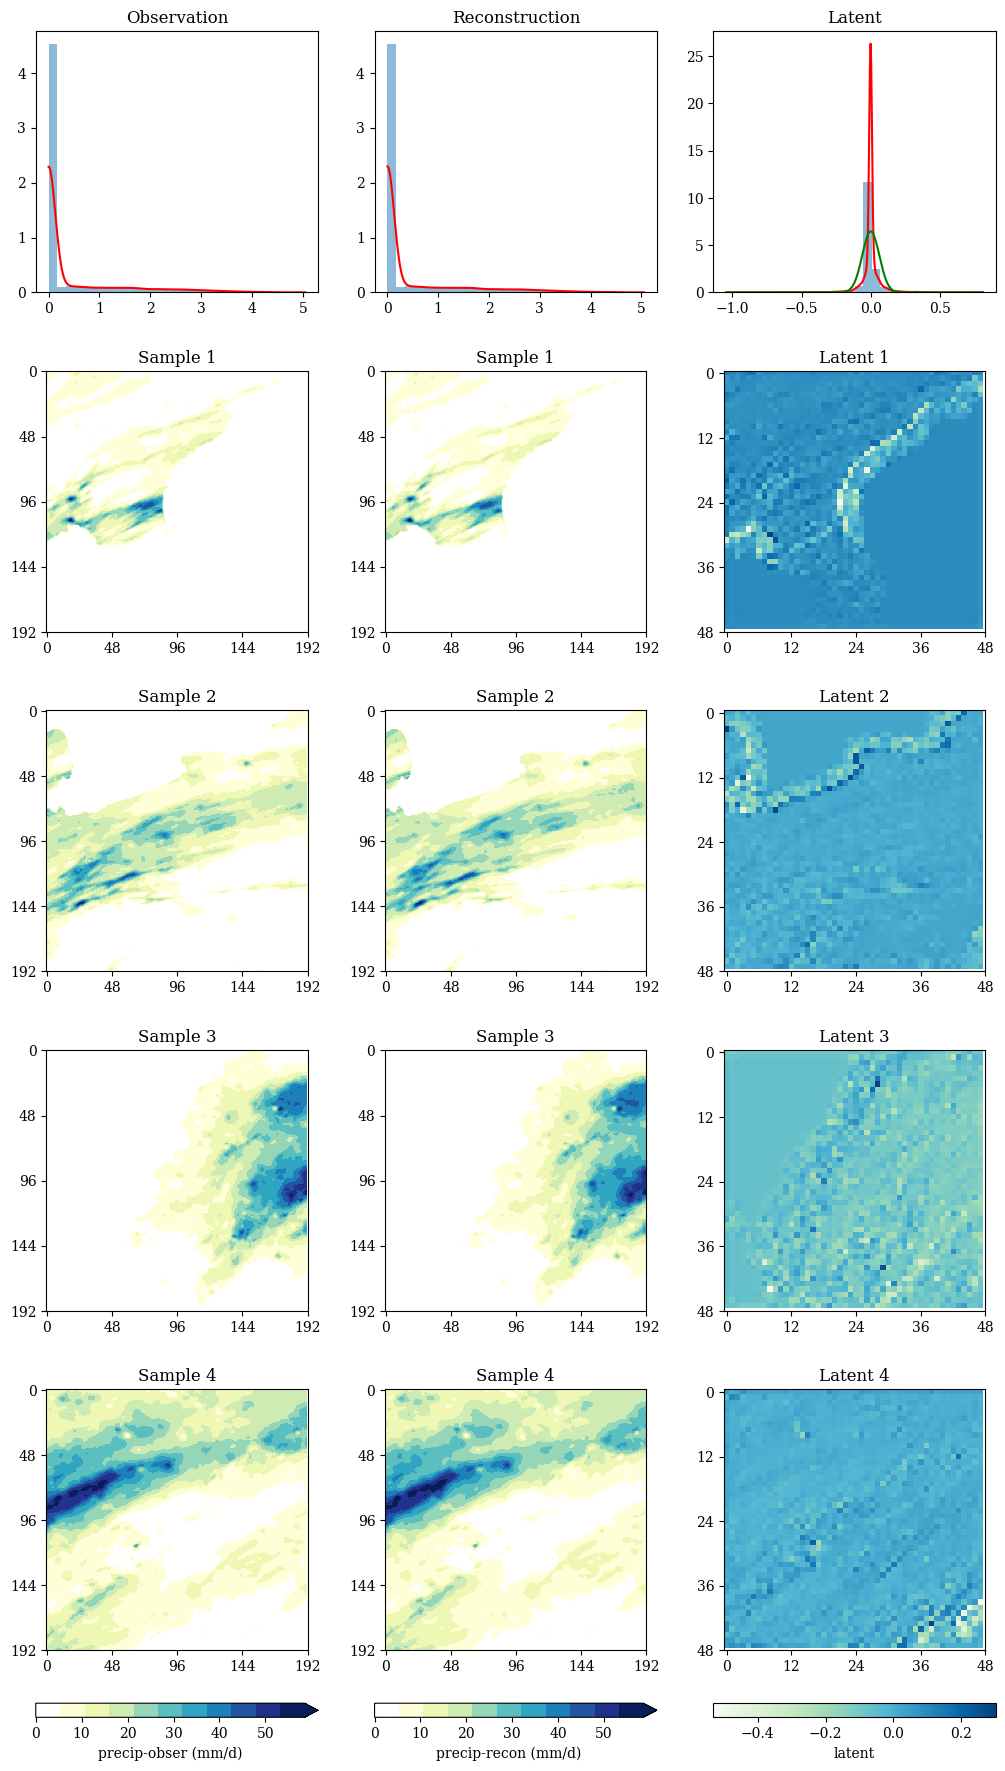

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde, norm
N24_CMAP = pcolors.ListedColormap([[1, 1, 1], [254 / 255, 254 / 255, 215 / 255], 
                                    [238 / 255, 248 / 255, 180 / 255], [205 / 255, 235 / 255, 179 / 255], 
                                    [149 / 255, 213 / 255, 184 / 255], [91 / 255, 191 / 255, 192 / 255],
                        [48 / 255, 165 / 255, 194 / 255], [30 / 255, 128 / 255, 184 / 255], [34 / 255, 84 / 255, 163 / 255],
                                   [33 / 255, 49 / 255, 140 / 255], [8 / 255, 29 / 255, 89 / 255]]) # 11
num_rows = 5
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 22))
plt.rcParams['font.family'] = 'serif'

for row, index in enumerate(random.sample(list_precip, num_rows-1), start=1):
    for col in range(num_cols):
        
        if col == 0:
            sub_grid = inverse_log_scaling(list_origin[index][0][0])
            im = axs[row, col].imshow(sub_grid, cmap=N24_CMAP)
            axs[row, col].set_title(f'Sample {row}')
            axs[row, col].set_xticks(np.arange(0, 192 + 1, step=48))
            axs[row, col].set_yticks(np.arange(0, 192 + 1, step=48))
        elif col == 1:
            sub_grid = inverse_log_scaling(list_recon[index][0][0])
            im = axs[row, col].imshow(sub_grid, cmap=N24_CMAP)
            axs[row, col].set_title(f'Sample {row}')
            axs[row, col].set_xticks(np.arange(0, 192 + 1, step=48))
            axs[row, col].set_yticks(np.arange(0, 192 + 1, step=48))
        else:
            sub_grid = list_latent[index][0][0]
            im1 = axs[row, col].imshow(sub_grid, cmap='GnBu')
            axs[row, col].set_title(f'Latent {row}')
            axs[row, col].set_xticks(np.arange(0, 48 + 1, step=12))
            axs[row, col].set_yticks(np.arange(0, 48 + 1, step=12))
        # axs[row, col].axis('off')

row = 0
for col in range(num_cols):
    if col == 0:
        data = input_dis
    elif col == 1:
        data = output_dis
    elif col == 2:
        data = inner_dis

    axs[row, col].hist(data, bins=30, density=True, alpha=0.5)
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)
    if col == 2:
        axs[row, col].plot(x_vals, y_vals, 'r', label='Latent')
        mu, sigma = np.mean(data), np.std(data)
        norm_dist = norm.pdf(x_vals, mu, sigma)
        axs[row, col].plot(x_vals, norm_dist, 'g', label='Normal')
    else:
        axs[row, col].plot(x_vals, y_vals, 'r')
    # axs[row, col].set_xlabel('Data')
    # axs[row, col].set_ylabel('Density')
    axs[row, col].set_title('%s' % ['Observation', 'Reconstruction', 'Latent'][col])

# fig.colorbar(im, ax=axs)

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)
# plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.08, extend='both')  # 0.065
colorbar1 = plt.colorbar(im, ax=axs[:, 0], orientation='horizontal', fraction=0.05, pad=0.03, extend='max')
colorbar1.set_label('precip-obser (mm/d)')  

colorbar2 = plt.colorbar(im, ax=axs[:, 1], orientation='horizontal', fraction=0.05, pad=0.03, extend='max')
colorbar2.set_label('precip-recon (mm/d)')  

colorbar3 = plt.colorbar(im1, ax=axs[:, 2], orientation='horizontal', fraction=0.05, pad=0.03)
colorbar3.set_label('latent')
# plt.show(), dpi=600
plt.savefig(r'/root/lwd/vae_result.tif', bbox_inches='tight')

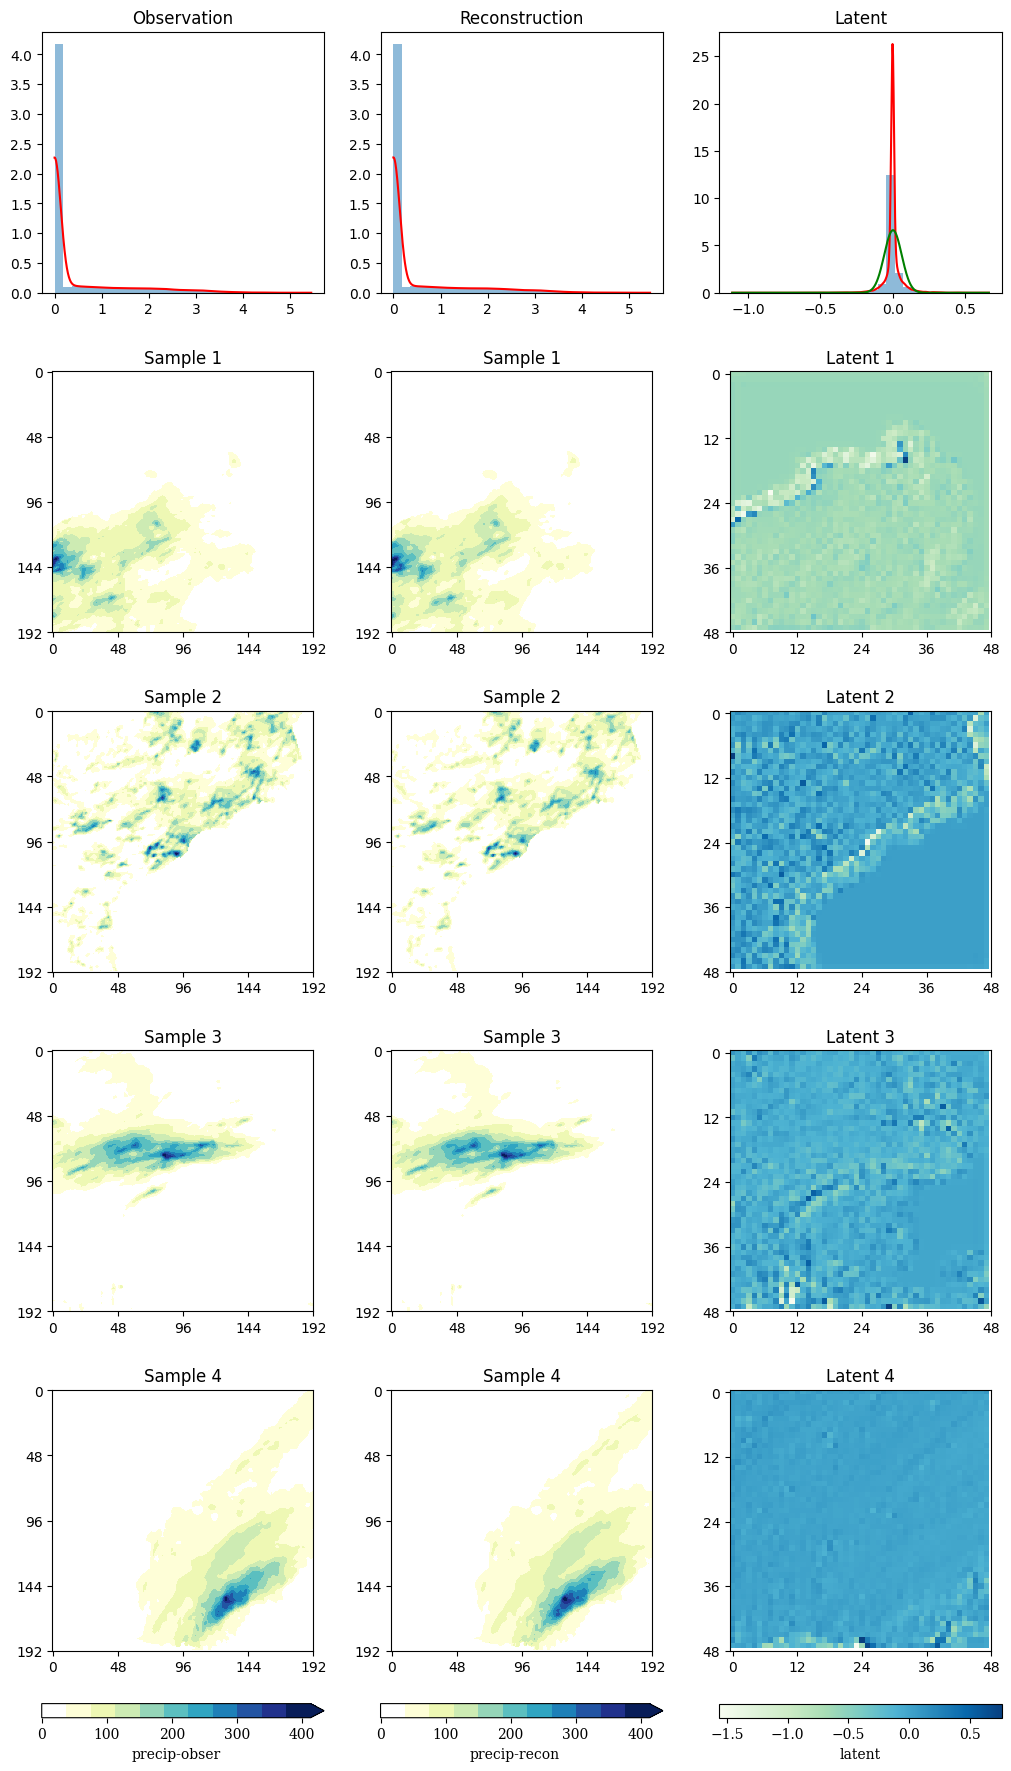

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde, norm
# plt.figure(figsize=(16, 28), dpi=300)
N24_CMAP = pcolors.ListedColormap([[1, 1, 1], [254 / 255, 254 / 255, 215 / 255], 
                                    [238 / 255, 248 / 255, 180 / 255], [205 / 255, 235 / 255, 179 / 255], 
                                    [149 / 255, 213 / 255, 184 / 255], [91 / 255, 191 / 255, 192 / 255],
                        [48 / 255, 165 / 255, 194 / 255], [30 / 255, 128 / 255, 184 / 255], [34 / 255, 84 / 255, 163 / 255],
                                   [33 / 255, 49 / 255, 140 / 255], [8 / 255, 29 / 255, 89 / 255]]) # 11
num_rows = 5
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 22))
plt.rcParams['font.family'] = 'serif'

for row, index in enumerate(random.sample(list_precip, num_rows-1), start=1):
    for col in range(num_cols):
        
        if col == 0:
            sub_grid = inverse_log_scaling(list_origin[index][0][0])
            im = axs[row, col].imshow(sub_grid, cmap=N24_CMAP)
            axs[row, col].set_title(f'Sample {row}')
            axs[row, col].set_xticks(np.arange(0, 192 + 1, step=48))
            axs[row, col].set_yticks(np.arange(0, 192 + 1, step=48))
        elif col == 1:
            sub_grid = inverse_log_scaling(list_recon[index][0][0])
            im = axs[row, col].imshow(sub_grid, cmap=N24_CMAP)
            axs[row, col].set_title(f'Sample {row}')
            axs[row, col].set_xticks(np.arange(0, 192 + 1, step=48))
            axs[row, col].set_yticks(np.arange(0, 192 + 1, step=48))
        else:
            sub_grid = list_latent[index][0][0]
            im1 = axs[row, col].imshow(sub_grid, cmap='GnBu')
            axs[row, col].set_title(f'Latent {row}')
            axs[row, col].set_xticks(np.arange(0, 48 + 1, step=12))
            axs[row, col].set_yticks(np.arange(0, 48 + 1, step=12))
        # axs[row, col].axis('off')

row = 0
for col in range(num_cols):
    if col == 0: # origin
        data = input_dis
    elif col == 1:
        data = output_dis
    elif col == 2:
        data = inner_dis

    axs[row, col].hist(data, bins=30, density=True, alpha=0.5)
    kde = gaussian_kde(data)
    x_vals = np.linspace(min(data), max(data), 1000)
    y_vals = kde(x_vals)
    if col == 2:
        axs[row, col].plot(x_vals, y_vals, 'r', label='Latent')
        mu, sigma = np.mean(data), np.std(data)
        norm_dist = norm.pdf(x_vals, mu, sigma)
        axs[row, col].plot(x_vals, norm_dist, 'g', label='Normal')
    else:
        axs[row, col].plot(x_vals, y_vals, 'r')
    # axs[row, col].set_xlabel('Data')
    # axs[row, col].set_ylabel('Density')
    axs[row, col].set_title('%s' % ['Observation', 'Reconstruction', 'Latent'][col])

# fig.colorbar(im, ax=axs)

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.3)
# plt.colorbar(im, orientation='horizontal', fraction=0.05, pad=0.08, extend='both')  # 0.065
colorbar1 = plt.colorbar(im, ax=axs[:, 0], orientation='horizontal', fraction=0.05, pad=0.03, extend='max')
colorbar1.set_label('precip-obser') 

colorbar2 = plt.colorbar(im, ax=axs[:, 1], orientation='horizontal', fraction=0.05, pad=0.03, extend='max')
colorbar2.set_label('precip-recon')  

colorbar3 = plt.colorbar(im1, ax=axs[:, 2], orientation='horizontal', fraction=0.05, pad=0.03)
colorbar3.set_label('latent')  
# plt.show()
plt.savefig(r'/root/lwd/vae_result.png')